In [39]:
! pip install nltk
! pip install wordcloud
!python -m spacy download en
!python -m spacy download en_core_web_sm
!pip install scikit-learn
!pip install -U spacy

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,classification_report, confusion_matrix , f1_score


from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

In [30]:
!pip install joblib
import joblib 
import pickle 

In [2]:
reviews = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
reviews.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
reviews.shape
reviews['Score'].value_counts()

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64

In [9]:
reviews.isnull().sum()



ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

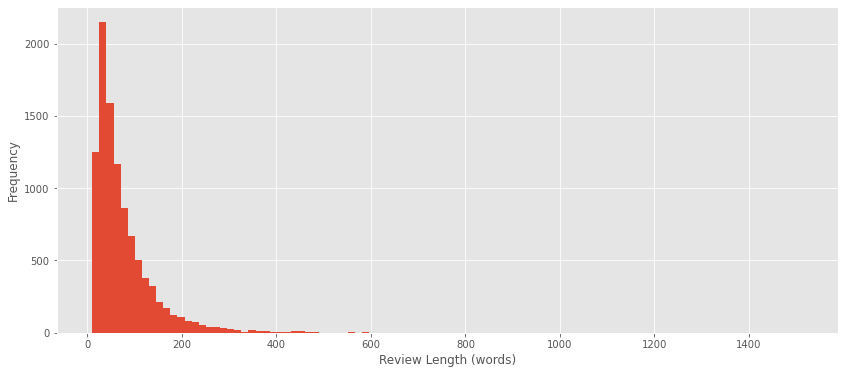

In [11]:
pre_review = reviews.Text.apply(lambda x: len(x.split(" ")))
pre_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [12]:
print('Average words:', pre_review.mean())
print('Skewness:', pre_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


In [13]:
score_val = 100 * reviews['Score'].value_counts()/len(reviews)
score_val 

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

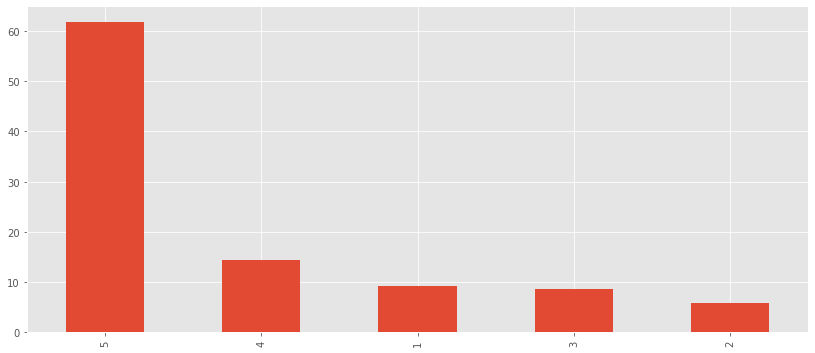

In [14]:
score_val.plot.bar()
plt.show()

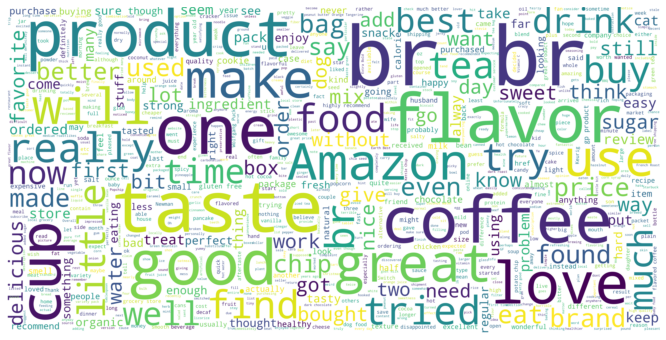

In [14]:
word_cloud_text = ''.join(reviews['Text'])

wordcloud = WordCloud(max_font_size=100, 
                      max_words=1000, 
                      background_color="white", 
                      scale = 10, 
                      width=800,
                      height=400 
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,interpolation="bilinear") 
plt.axis("off")
plt.show()

In [15]:
reviews['Sentiment_rating'] = np.where(reviews.Score > 3,1,0)
reviews = reviews[reviews.Score != 3]
reviews['Sentiment_rating'].value_counts()

1    7616
0    1522
Name: Sentiment_rating, dtype: int64

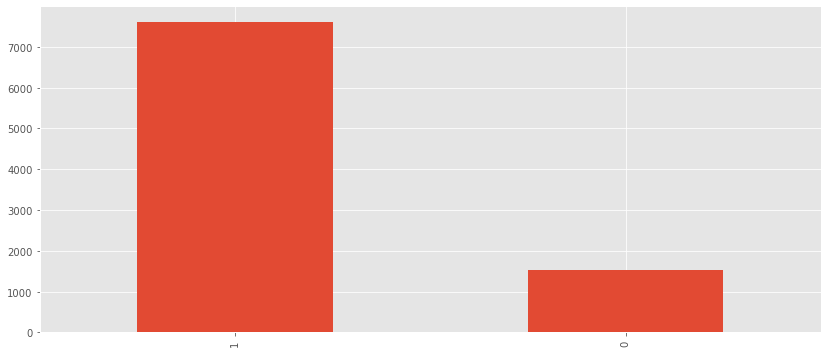

In [16]:
reviews['Sentiment_rating'].value_counts().plot.bar()
plt.show()

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
import string
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
stopwords = list(STOP_WORDS)
print(stopwords)

['give', 'only', 'once', 'us', 'very', 'every', 'thereby', 'well', 'becoming', 'now', 'whereas', 'why', 'elsewhere', 'does', 'though', 'be', 'towards', 'same', 'they', 'fifteen', 'thus', 'behind', 'is', 'most', 'all', 'other', 'everyone', 'part', 'ours', 'anyway', 'wherever', 'off', 'before', 'into', 'which', 'should', 'where', 'anything', 'put', 'first', 'throughout', 'else', 'nine', 'sometime', 'quite', "'re", 'she', '‘m', "n't", 'various', 'empty', 'although', 're', 'yourselves', 'hereupon', 'twenty', 'fifty', 'done', 'noone', 'another', 'this', 'back', 'him', 'those', 'her', '‘ve', 'out', 'had', 'make', 'whither', 'yourself', 'been', 'amongst', 'since', 'formerly', 'enough', 'many', 'may', '’ve', '’m', 'last', 'while', 'you', 'ever', 'show', 'eight', 'am', 'are', 'upon', 'sometimes', 'of', 'whether', 'unless', 'already', 'became', 'thereafter', 'see', 'along', 'beyond', '‘d', 'via', 'mine', 'below', 'ourselves', 'say', 'amount', 'meanwhile', 'among', 'latter', 'yours', "'m", 'where

In [9]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return set(cleaned_tokens)

In [10]:
text_data_cleaning("this is a good place .")

{'good', 'place'}

In [21]:
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier1 = LinearSVC()
X = reviews['Text']
y = reviews['Sentiment_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((7310,), (1828,))

In [22]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier1)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001E33C4673A0>)),
                ('clf', LinearSVC())])

In [23]:
X_train

3822    If you liked licorice as a child, this is a dr...
6272    I had never made this or had it at a mexican f...
4421    I was just going to reorder the "Bit-O-Honey" ...
6209    The only other flavored coffee I've used was N...
233     Terrible! Artificial lemon taste, like Pledge ...
                              ...                        
6208    Before I say anything else, I am mindful of di...
5628    These are very healthy 7 grains and very light...
5838    This product is delicious!  It is the frappaci...
934     I have 12 month olds and no time to write a gr...
7942    This stuff is the bomb.<br />There is no peppe...
Name: Text, Length: 7310, dtype: object

In [24]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.60      0.69       282
           1       0.93      0.97      0.95      1546

    accuracy                           0.91      1828
   macro avg       0.86      0.79      0.82      1828
weighted avg       0.91      0.91      0.91      1828



In [72]:
clf.predict(['it is a good place ! '])

array([1.])

In [26]:
print(confusion_matrix(y_test , y_pred))

[[ 170  112]
 [  44 1502]]


In [27]:
classifier2 = MultinomialNB() 

In [27]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier2)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001EFBE94A550>)),
                ('clf', MultinomialNB())])

In [28]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       282
           1       0.85      1.00      0.92      1546

    accuracy                           0.85      1828
   macro avg       0.92      0.50      0.46      1828
weighted avg       0.87      0.85      0.78      1828



In [29]:
print(confusion_matrix(y_test , y_pred))

[[   1  281]
 [   0 1546]]


In [30]:
classifier3=LogisticRegression()

In [31]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier3)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001EFBE94A550>)),
                ('clf', LogisticRegression())])

In [32]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.32      0.47       282
           1       0.89      0.99      0.94      1546

    accuracy                           0.89      1828
   macro avg       0.90      0.65      0.70      1828
weighted avg       0.89      0.89      0.87      1828



In [28]:
pip install imblearn --user

In [29]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
oversampling=RandomOverSampler(sampling_strategy='minority')

In [19]:
new_data1=reviews.loc[:, ["Text"]]
new_data2=reviews.loc[:, ["Sentiment_rating"]]
new_data1.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [20]:
new_data=reviews.loc[:, ["Text","Sentiment_rating"]]
new_data.head(10)

,Text,Sentiment_rating
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1
7,This taffy is so good. It is very soft and ch...,1
8,Right now I'm mostly just sprouting this so my...,1
9,This is a very healthy dog food. Good for thei...,1


In [21]:
X_over, y_over = oversampling.fit_resample(new_data1,new_data2)

In [22]:
X_over,y_over

(                                                    Text
 0      I have bought several of the Vitality canned d...
 1      Product arrived labeled as Jumbo Salted Peanut...
 2      This is a confection that has been around a fe...
 3      If you are looking for the secret ingredient i...
 4      Great taffy at a great price.  There was a wid...
 ...                                                  ...
 15227  I'm recently widowed so have to learn to fix f...
 15228  We have been feeding this to our dogs for over...
 15229  Not a big fan.  Will not buy this again.  plus...
 15230  Received 6 bottles of concentrate from Paragon...
 15231  I don't expect great hot chocolate from a k-cu...
 
 [15232 rows x 1 columns],
        Sentiment_rating
 0                     1
 1                     0
 2                     1
 3                     0
 4                     1
 ...                 ...
 15227                 0
 15228                 0
 15229                 0
 15230                 0


In [23]:
from collections import Counter

In [24]:
frames=[X_over, y_over]
result=pd.concat(frames)
test= result["Text"].isna().value_counts()
result[15232:].head()


,Text,Sentiment_rating
0,NaN,1.0
1,NaN,0.0
2,NaN,1.0
3,NaN,0.0
4,NaN,1.0


In [25]:
result[:15232].tail()

,Text,Sentiment_rating
15227,I'm recently widowed so have to learn to fix f...,NaN
15228,We have been feeding this to our dogs for over...,NaN
15229,Not a big fan. Will not buy this again. plus...,NaN
15230,Received 6 bottles of concentrate from Paragon...,NaN
15231,I don't expect great hot chocolate from a k-cu...,NaN


In [26]:
result[result["Sentiment_rating"].isna()]["Text"]


0        I have bought several of the Vitality canned d...
1        Product arrived labeled as Jumbo Salted Peanut...
2        This is a confection that has been around a fe...
3        If you are looking for the secret ingredient i...
4        Great taffy at a great price.  There was a wid...
                               ...                        
15227    I'm recently widowed so have to learn to fix f...
15228    We have been feeding this to our dogs for over...
15229    Not a big fan.  Will not buy this again.  plus...
15230    Received 6 bottles of concentrate from Paragon...
15231    I don't expect great hot chocolate from a k-cu...
Name: Text, Length: 15232, dtype: object

In [27]:
f={"text":result[:15232]["Text"],"rating":result[15232:]["Sentiment_rating"]}
fresult=pd.DataFrame(f)
fresult


,text,rating
0,I have bought several of the Vitality canned d...,1.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,1.0
3,If you are looking for the secret ingredient i...,0.0
4,Great taffy at a great price. There was a wid...,1.0
...,...,...
15227,I'm recently widowed so have to learn to fix f...,0.0
15228,We have been feeding this to our dogs for over...,0.0
15229,Not a big fan. Will not buy this again. plus...,0.0
15230,Received 6 bottles of concentrate from Paragon...,0.0


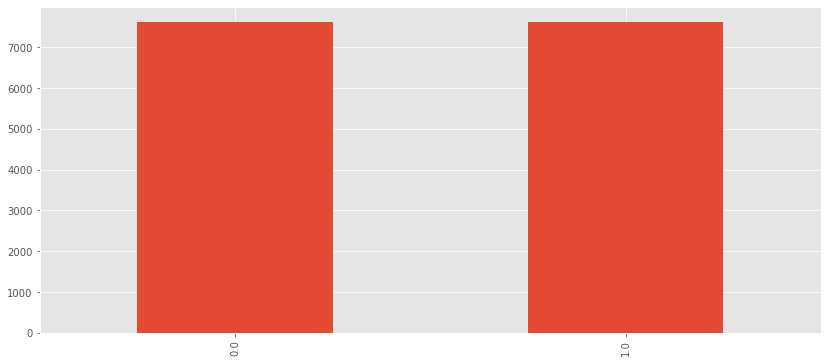

In [28]:
fresult['rating'].value_counts().plot.bar()
plt.show()

In [41]:
fresult["text"].describe()

count                                                 15232
unique                                                 8716
top       This flavor is horrible.  There are many other...
freq                                                     19
Name: text, dtype: object

# Aprés le Random_Oversampling

In [61]:
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier1 = LinearSVC()
X = fresult['text']
y = fresult['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((12185,), (3047,))

In [62]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier1)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001E33C4673A0>)),
                ('clf', LinearSVC())])

In [29]:
joblib.dump(clf,'linearSVC_model')

NameError: name 'joblib' is not defined

In [97]:
clf.predict(["The scallop and crab risotto was a bomb. "])

array([1.])

In [93]:
f1=open('linearSVC.pkl','wb')
pickle.dump(clf,f1)
f1.close()

In [86]:
with open('linearSVC_pmodel','rb') as f1:
    model=pickle.load(f1)

In [87]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      1472
         1.0       0.95      0.91      0.93      1575

    accuracy                           0.93      3047
   macro avg       0.93      0.93      0.93      3047
weighted avg       0.93      0.93      0.93      3047



In [65]:
joblib.dump(clf,'./models/linearSVC_model')

['./models/linearSVC_model']

In [64]:
mod=joblib.load('linearSVC_model')
y_pred = mod.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1472
         1.0       0.99      0.93      0.96      1575

    accuracy                           0.96      3047
   macro avg       0.96      0.96      0.96      3047
weighted avg       0.96      0.96      0.96      3047



In [44]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1472
         1.0       0.99      0.93      0.96      1575

    accuracy                           0.96      3047
   macro avg       0.96      0.96      0.96      3047
weighted avg       0.96      0.96      0.96      3047



In [45]:
print(confusion_matrix(y_test , y_pred))

[[1450   22]
 [ 108 1467]]


In [46]:
classifier2 = MultinomialNB() 

In [66]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier2)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001E33C4673A0>)),
                ('clf', MultinomialNB())])

In [88]:
with open('naivebayes_pmodel','wb') as f1:
    pickle.dump(clf,f1)

In [89]:
with open('naivebayes_pmodel','rb') as f1:
    model=pickle.load(f1)

In [67]:
joblib.dump(clf,'./models/naivebayes_model')

['./models/naivebayes_model']

In [48]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      1472
         1.0       0.94      0.88      0.91      1575

    accuracy                           0.91      3047
   macro avg       0.91      0.91      0.91      3047
weighted avg       0.91      0.91      0.91      3047



In [49]:
print(confusion_matrix(y_test , y_pred))

[[1376   96]
 [ 186 1389]]


In [50]:
classifier3=LogisticRegression()

In [68]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier3)])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x000001E33C4673A0>)),
                ('clf', LogisticRegression())])

In [82]:
clf.predict(["this is a great place "])

array([1.])

In [91]:
with open('logisticregression_pmodel','wb') as f1:
    pickle.dump(clf,f1)

In [69]:
joblib.dump(clf,'./models/logisticregression_model')

['./models/logisticregression_model']

In [81]:
mod=joblib.load("C:\Users\waelz\Desktop\pc acer\PCD\models\linearSVC_model")
#y_pred = mod.predict(X_test)
a=mod.predict(["this is a good place"])
#print(classification_report(y_test, y_pred))

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-81-fdcc128b0707>, line 1)

In [80]:
a

array([1.])

In [52]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      1472
         1.0       0.95      0.91      0.93      1575

    accuracy                           0.93      3047
   macro avg       0.93      0.93      0.93      3047
weighted avg       0.93      0.93      0.93      3047



In [53]:
print(confusion_matrix(y_test , y_pred))

[[1402   70]
 [ 140 1435]]


In [73]:
mod=joblib.load("./models/linearSVC_model")
x=mod.predict(["this is a good place"])

In [ ]:
x
